# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>

In this eight notebook we want to variationally optimize the ground state of a single quantum particle in a one dimensional space and estimate its energy sampling also the squared module of the wave function $|\psi_T(x)|^2$. Then, exploiting the provided code(PIMC/PIGS), we vary the temperature inspecting the configuration differences.

We analyze the case of a single quantum particle in a one dimensional space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

Such a model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, we use the Variational Monte Carlo method.


This method exploits the fact that the variational energy $E_T$ of a given trial wave function $\psi_T$ is always greater than the energy of the ground state $E_0$:
$$
\langle {\hat H} \rangle_T = \frac{\langle \psi_T^{\sigma,\mu}| {\hat H} | \psi_T^{\sigma,\mu} \rangle}
{\langle \psi_T^{\sigma,\mu} | \psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

In this fashion, it is clear that $E_T$ is minimum when coincides with $E_0$, i.e. when $\psi_T$ coincides with $\Psi_0$. Exploiting this, we can find the energy of the ground state as the minimum of the energy estimated.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D

### Exercise 08.1

In the first exercise we face the problem of the variational optimization. 
In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters.
A model for the ground state wave function is the following trial wave function:
$$
\psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$ 
As we can see, $\psi_T^{\sigma,\mu}(x)$ depends on two variational parameters, $\sigma$, which is the square root of the width of the two Gaussians, and $\mu$, which represents the distance from the origin of their average values.
Exploiting the variational optimization, we are able to find $\mu$ and $\sigma$ which minimize the energy.
In order to do so we write a code which evaluates the energy as a function of $\mu$ and $\sigma$.
Furthermore, we implement the Metropolis algorithm useful to sample the trial wave function $|\psi_T(x)|^2$ using a uniform transition probability $T(x_{new}|x_{old})$.
We simply adapt the code of **LSN_05** used for the sampling of the hydrogen wavefunctions.

In order to obtain the energy minimum, we write a code implementing the data blocking and computing the expectation value for the Hamiltonian:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \psi_T(x)}
{\int dx |\psi_T(x)|^2} = 
\int dx \frac{|\psi_T(x)|^2}{\int dx |\psi_T(x)|^2} \frac{{\hat H} \psi_T(x)}{\psi_T(x)}.
$$

Such a computation is made varying the variational parameters $\mu \in [0.52,0.8]$ and $\sigma \in [0.52,0.8]$ making steps of $\Delta \mu = \Delta \sigma = 0.02$.
For each different couple $(\mu, \sigma)$, before evaluating the energy, we perform an optimization of the Metropolis delta, imposing that the acceptance rate is about 50%. Then we equilibrate the system performing $1000$ equilibration steps and finally we evaluate the energy. Such evaluation is done exploiting the data blocking procedure: we take only the last value after $100$ blocks made of $3000$ steps each.

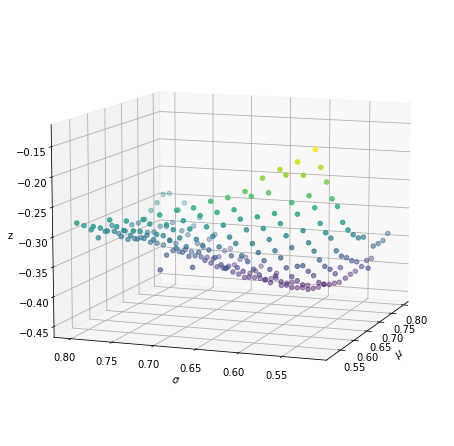

In [63]:
mu, sigma, energy = np.loadtxt("data/ex8.1.2/params_optimization.dat", usecols= (0,1,2), dtype="float,float,float",unpack=True)

figure = plt.figure(figsize=(8, 6))
p3D = Axes3D(figure)
p3D.scatter(mu, sigma, energy, c=energy)
p3D.set_xlabel(r"$\mu$")
p3D.set_ylabel(r"$\sigma$")
p3D.set_zlabel("z")
p3D.view_init(10, 200)
plt.show()

### Exercise 08.2

The first exercise is a kind of preparation for this second exercise, in which we make the estimation of the Ground State energy.
In order to estimate  $\langle {\hat H} \rangle_T$ we have to resort to the analytical calculation of the second derivative of $\psi_T^{\sigma,\mu}$. In particular, the estimated energy can be written as: 

$$\langle {\hat H} \rangle_T = \frac{{\frac{\partial^2}{\partial x^2}} \psi_T^{\sigma,\mu}(x)}{2\psi_T^{\sigma,\mu}(x)} + V(x), $$
where the first addendum is relative to the kinetic energy.
Also in this case we resort to data blocking: we make $500$ equilibration steps followed by $10^6$ steps divided in $100$ blocks. 

In [81]:
#define the potential and perform analytical calculations of the Ground State energy
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

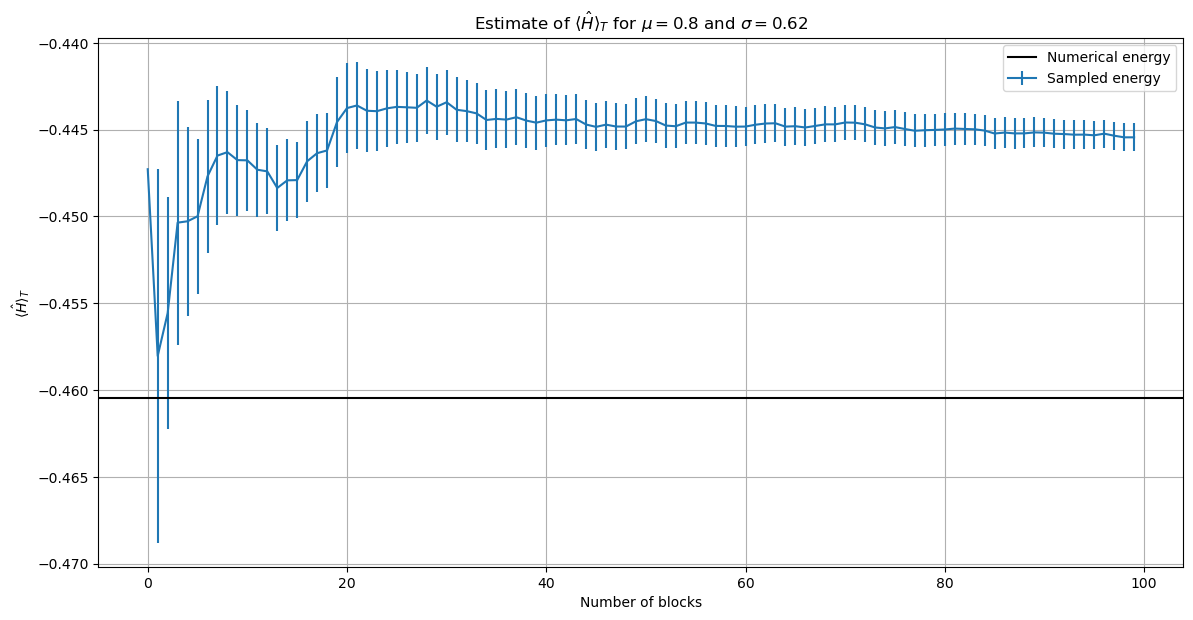

In [65]:
ave_ene,err_ene=np.loadtxt("data/ex8.1.2/hamiltonian.dat", dtype="float,float", unpack=True)

n_blocks = range(100)

figure =plt.figure(figsize=(14,7), dpi=100)
plt.axhline(E[0], 0,100, color="black",linestyle="solid", label = "Numerical energy")

plt.errorbar(n_blocks,ave_ene,yerr=err_ene, label = "Sampled energy")
plt.title(r"Estimate of $\langle \hat{H} \rangle_T$ for $\mu = 0.8$ and $\sigma = 0.62$")
plt.xlabel(r"Number of blocks")
plt.ylabel(r"$\langle \hat{H} \rangle_T$")
plt.grid(True) 
plt.legend()
plt.show()

In the above plot we show the estimation of $\langle {\hat H} \rangle_T$ for the value of the variational parameters which minimize the Ground State energy: $$\mu = 0.8 \, \, \, ;\,  \, \, \sigma = 0.62$$ In particular we obtain: $$\langle {\hat H} \rangle_T = -0.4454 \pm 0.0008.$$
In the plot we also show the energy value calculated analytically: it is represented by the black solid line. Such value corresponds to the limit $ E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}.$

Now, we show a picture of the sampled $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations and compare it  with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation.

In [66]:
sigma = 0.62
mu = 0.8
def an_wavefun(x, mu, sigma):
    psi_t = np.exp(-0.5*pow((x-mu)/sigma,2)) + np.exp(-0.5*pow((x+mu)/sigma,2))
    norm = 2.*np.sqrt(np.pi)*sigma*(1 + np.exp(-(mu/sigma)**2)) 
    return psi_t**2/ norm

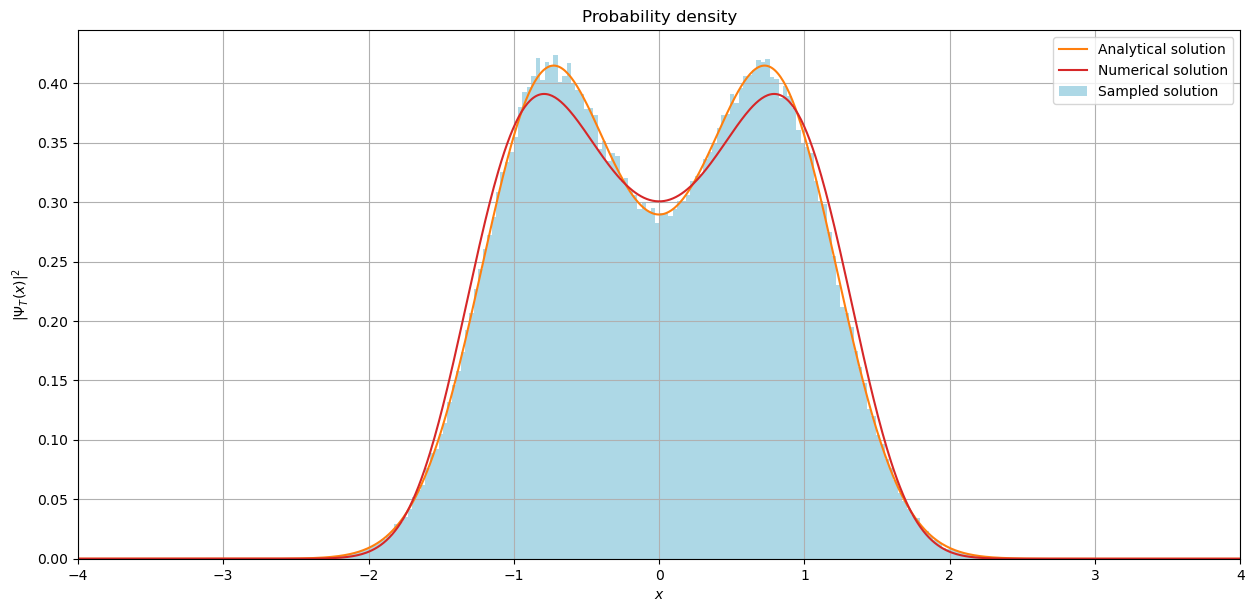

In [67]:
positions=np.loadtxt("data/ex8.1.2/positions.dat")

fig=plt.figure(figsize=(15, 7), dpi = 100)

plt.hist(positions,180,color = "lightblue", density=True, label="Sampled solution")
plt.plot(x, an_wavefun(x,mu,sigma), color = "C1", label="Analytical solution")
plt.plot(x,(psi[0])**2, color="C3", label="Numerical solution")

plt.title("Probability density")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi_T(x)|^2$")
plt.xlim(-4,4)
plt.grid(True)
plt.legend()
plt.show()

### Exercise 08.3

In the last exercise we use the PIMC/PIGS code to study the same 1D quantum system.
Firstly, we use the PIGS algorithm code ($T=0$) to project a constant trial wave function $\psi_T(x)=1$ and the optimized trial wave function $\psi_T(x) = \psi_T^{\sigma,\mu}(x)$  with the optimal variational parameters $(\mu, \sigma) = (0.8,0.62)$.
In particular is our intention to compare our results with those obtained in the previous exercises and study the possible reduction of the imaginary time propagation. 
The simulation is preceded by an equilibration of $2000$ steps and is composed by $20$ blocks made of $4000$ steps each.

#### Constant trial wave function $\psi_T(x)=1$

Inter alia, we adapt the code and the input parameters to our case, modifying the external potential and setting the variational wavefunction to $1$. We consider imaginary time equal to $\tau=8$ divided in $300$ timeslices. The probability distributions showed in the plots below are the results of the analysis performed on the timeslices between $120$ and $180$, which are the slices in which the algorithm better approximates the ground state, even if it does not know it. 
In order to obtain an acceptance rate about $0.50$, we set:
- brownian motion reconstructions: $65$
- delta translations: $0.55$
- brownian bridge reconstructions: $110$

and leave invariate the other parameters.

#### Optimized trial wave function $\psi_T(x) = \psi_T^{\sigma,\mu}(x)$

We operate in the same way also for the optimized variational wave function $\psi_T(x) = \psi_T^{\sigma,\mu}(x)$.
At this point we can compare the results obtained in this case with the previous one.

First of all we show the comparison of the probability densities.

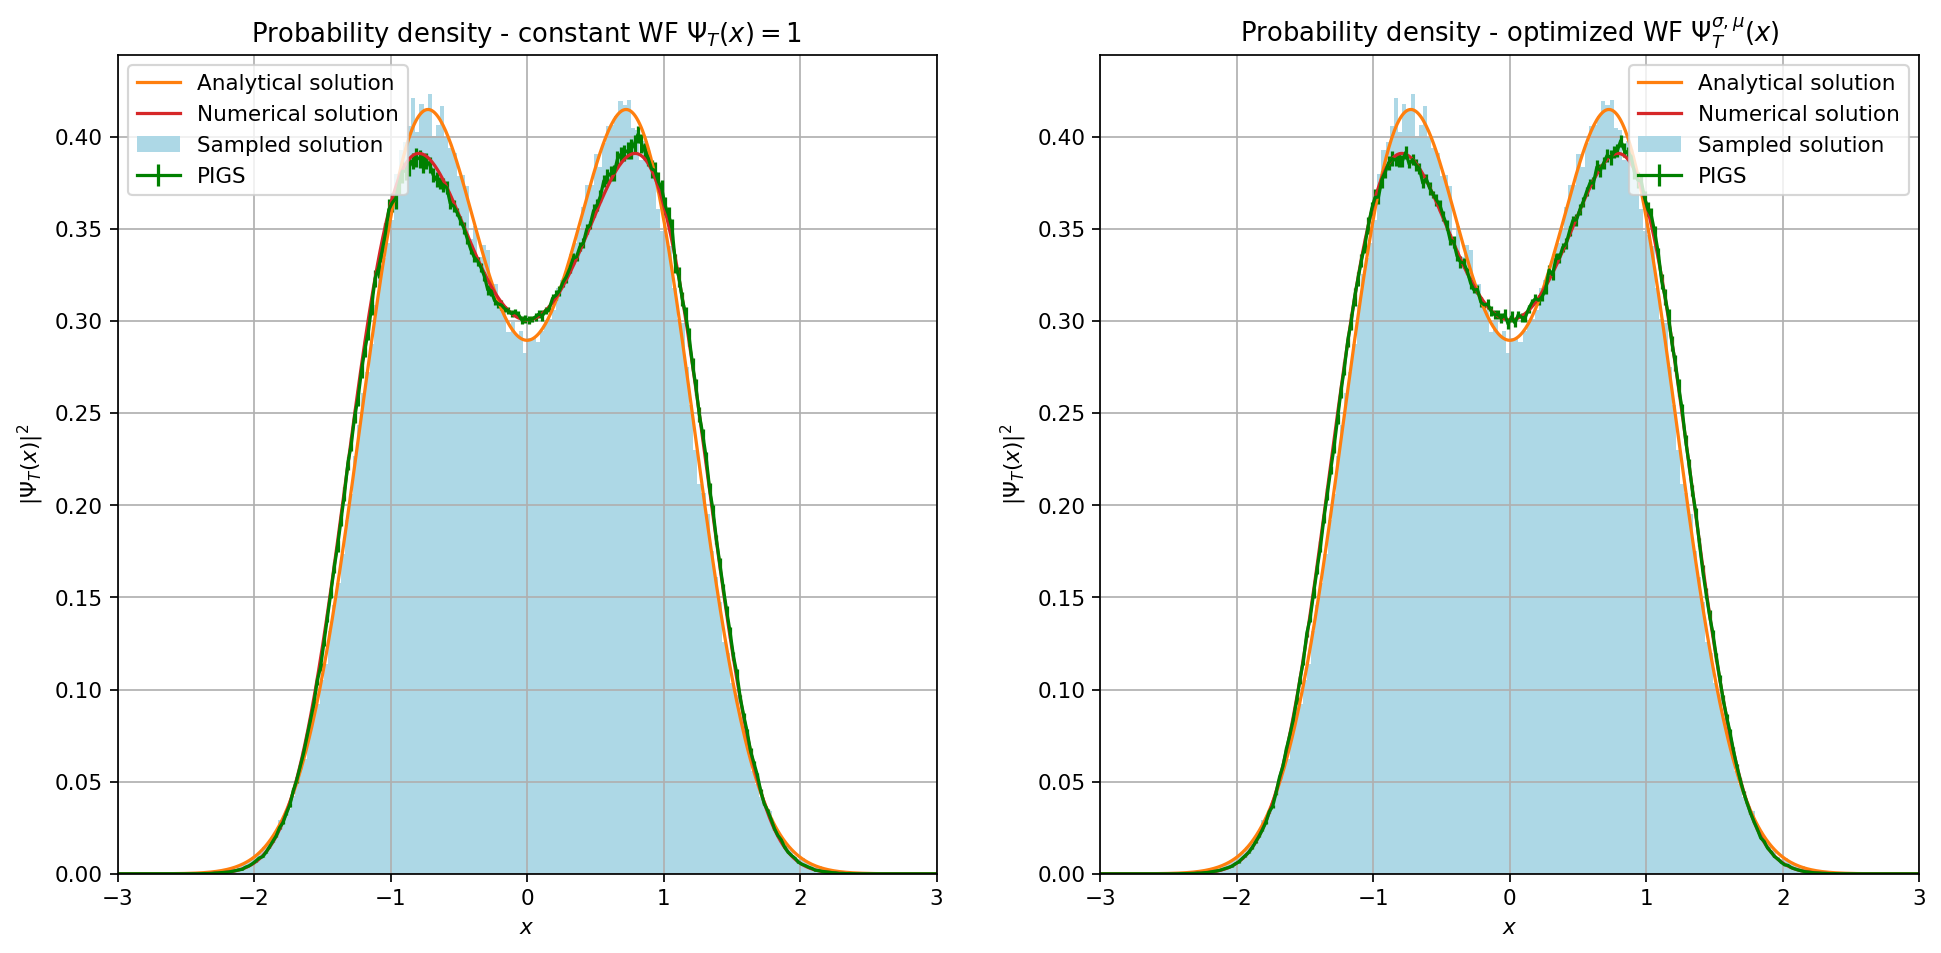

In [68]:
x_const, y_const, err_const = np.loadtxt("data/ex8.3/PIGS/Constant/constWF8/probability.dat", usecols=(0,1,2), unpack=True)
x_opt, y_opt, err_opt = np.loadtxt("data/ex8.3/PIGS/Optimized/optWF8/probability.dat", usecols=(0,1,2), unpack=True)

fig, pp=plt.subplots(1,2, figsize=(15,7), dpi=155)

pp[0].hist(positions,180,color = "lightblue", density=True, label="Sampled solution")
pp[0].plot(x, an_wavefun(x,mu,sigma), color = "C1", label="Analytical solution")
pp[0].plot(x,(psi[0])**2, color="C3", label="Numerical solution")
pp[0].errorbar(x_const, y_const, err_const, color='green', label="PIGS")
pp[0].set_title(r"Probability density - constant WF $\psi_T(x) = 1$")
pp[0].set_xlabel(r"$x$")
pp[0].set_ylabel(r"$|\psi_T(x)|^2$")
pp[0].set_xlim(-3,3)
pp[0].legend()
pp[0].grid(True)



pp[1].hist(positions,180,color = "lightblue", density=True, label="Sampled solution")
pp[1].plot(x, an_wavefun(x,mu,sigma), color = "C1", label="Analytical solution")
pp[1].plot(x,(psi[0])**2, color="C3", label="Numerical solution")
pp[1].errorbar(x_opt, y_opt, err_opt, color='green', label="PIGS")
pp[1].set_title(r"Probability density - optimized WF $\psi_T^{\sigma,\mu}(x)$")
pp[1].set_xlabel(r"$x$")
pp[1].set_ylabel(r"$|\psi_T(x)|^2$")
pp[1].set_xlim(-3,3)
pp[1].legend()
pp[1].grid(True)


The first thing we can observe from the above plots is that PIGS algorithm leads to results more similar to the Numerical solution than to the analytical one. This is exactly the reason why we say that PIGS algorithm is exact: the probability distribution of the ground state lies between the statistical uncertainties estimated with such algorithm.
These observations can be made on both the plots, i.e. they do not depend on the chosen starting wave function. 
We underline that the two plots are statistically equal since we evaluate the system between the timeslices 120 and 180; doing so we're giving enough time to the **ket** and **bra** to be 
sufficiently projected.

We compare also the expectation values for the energy:

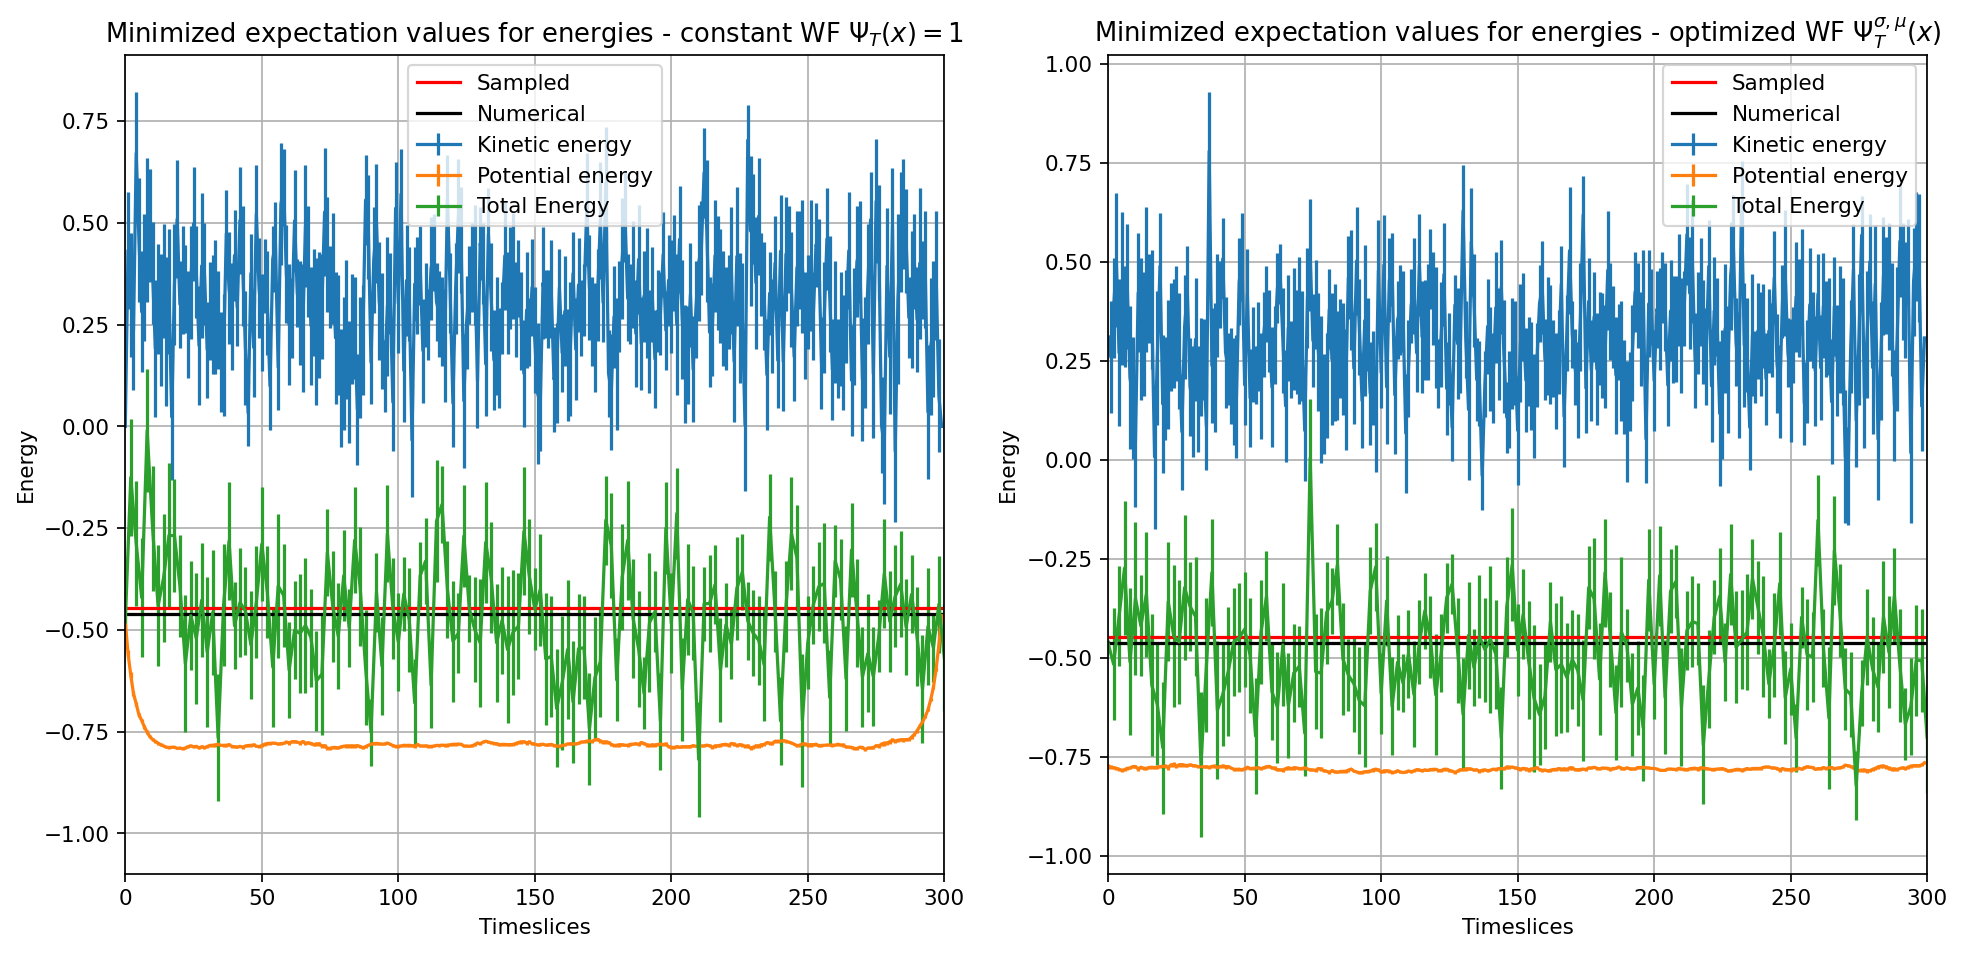

In [69]:
x_kin_const, y_kin_const, err_kin_const = np.loadtxt("data/ex8.3/PIGS/Constant/constWF8/kinetic.dat", usecols=(0,1,2), unpack=True)
x_pot_const, y_pot_const, err_pot_const = np.loadtxt("data/ex8.3/PIGS/Constant/constWF8/potential.dat", usecols=(0,1,2), unpack=True)
x_kin_opt, y_kin_opt, err_kin_opt = np.loadtxt("data/ex8.3/PIGS/Optimized/optWF8/kinetic.dat", usecols=(0,1,2), unpack=True)
x_pot_opt, y_pot_opt, err_pot_opt = np.loadtxt("data/ex8.3/PIGS/Optimized/optWF8/potential.dat", usecols=(0,1,2), unpack=True)

                                               
fig, pp = plt.subplots(1,2, figsize=(15,7), dpi=155)

pp[0].set_title(r"Minimized expectation values for energies - constant WF $\psi_T(x) = 1$")
pp[0].errorbar(x_kin_const, y_kin_const, err_kin_const, label="Kinetic energy")
pp[0].errorbar(x_pot_const, y_pot_const, err_pot_const, label="Potential energy")
#we do the quadratic sum for the errors
pp[0].errorbar(x_kin_const + x_pot_const, y_kin_const + y_pot_const, (err_kin_const**2+err_pot_const**2)**0.5 , label="Total Energy")
pp[0].axhline(ave_ene[99], 0, 300, color="red", label="Sampled")
pp[0].axhline(E[0], 0, 300, color="black", label='Numerical')
pp[0].set_ylabel("Energy")
pp[0].set_xlabel("Timeslices")
pp[0].set_xlim(0,300)
pp[0].legend()
pp[0].grid(True)


pp[1].set_title(r"Minimized expectation values for energies - optimized WF $\psi_T^{\sigma,\mu}(x)$")
pp[1].errorbar(x_kin_opt, y_kin_opt, err_kin_opt, label="Kinetic energy")
pp[1].errorbar(x_pot_opt, y_pot_opt, err_pot_opt, label="Potential energy")
pp[1].errorbar(x_kin_opt + x_pot_opt, y_kin_opt + y_pot_opt, (err_kin_opt**2+err_pot_opt**2)**0.5 , label="Total Energy")
pp[1].axhline(ave_ene[99], 0, 300, color="red", label="Sampled")
pp[1].axhline(E[0], 0, 300, color="black", label='Numerical')
pp[1].set_ylabel("Energy")
pp[1].set_xlabel("Timeslices")
pp[1].set_xlim(0,300)
pp[1].legend()
pp[1].grid(True)

In the above plot we show the values of energies and the expectation values $\langle {\hat H} \rangle$ obtained both, using the variational Monte Carlo (red line) and transforming the Schrodinger equation into a matrix equation (black line). As we can see, both values are in agreement with the tota energy values obtained with PIGS algorithm.

It is good to linger on these plots to observe again the differences given by the different choice of the starting wave function; indeed, we can notice that for the terminal values of the timeslices potential energy in the plot on the left is greater than the potential energy for timeslices between $50$ and $250$. Again, this is due to the fact that it is necessary to project both, **ket** and **bra**. 
This behaviour is observed only in case we choose a wave function different from the Ground State; In fact, looking at the plot on the right, we can see that there is not such behaviour. This is due to the fact that the starting wave function is optimized and it is similar enough to the Ground State.

Starting from this observations, we ask ourselves how long we have to wait in order to have a satisfying projection of the starting wave function on the Ground State.

In order to understand so, we compute the probability distributions for different imaginary time propagation values $\tau$.
We perform this calculation both, for constant and optimized starting wave function.

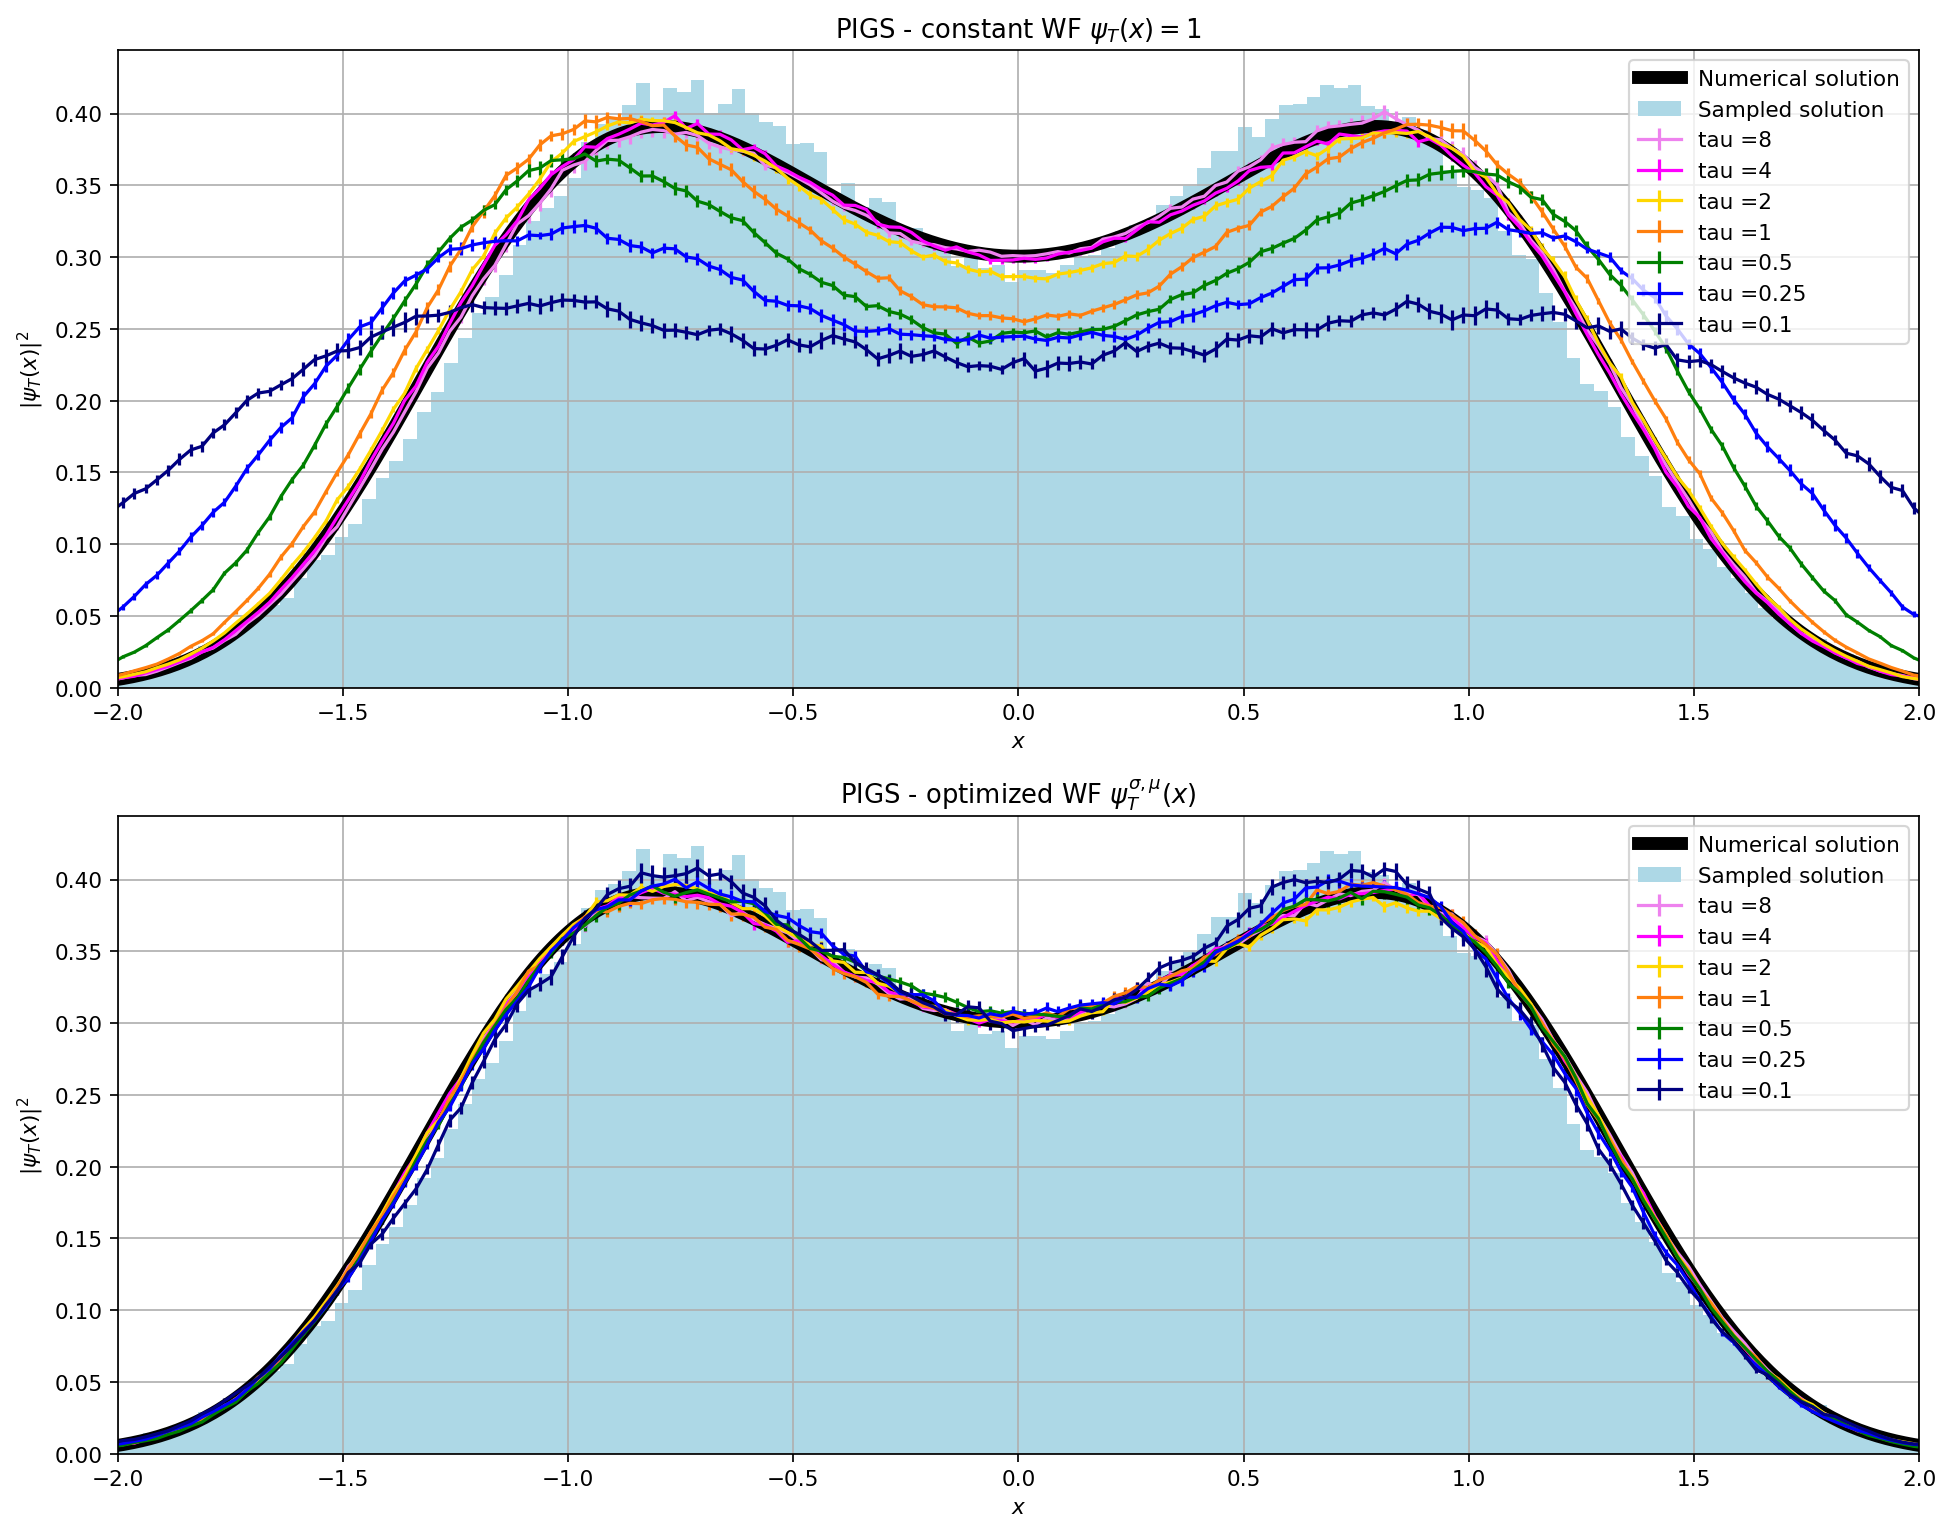

In [77]:
tau=[8,4,2,1,0.5,0.25,0.1]

colors=["violet","fuchsia", "gold", "C1", "green", "blue","navy"]

fig, pp = plt.subplots(2,1, figsize=(15,12), dpi=155)

pp[0].hist(positions,180, color="lightblue", density=True, label="Sampled solution")
for i in range(7):
    x_c, y_c, err_c = np.loadtxt("data/ex8.3/PIGS/Constant/constWF"+str(tau[i])+"/probability.dat", usecols=(0,1,2), unpack=True)
    pp[0].errorbar(x_c, y_c,yerr=err_c, color = colors[i], label="tau ="+str(tau[i]))
    
pp[0].plot(x,(psi[0])**2, color="black",linewidth=6, label="Numerical solution")
pp[0].set_title("PIGS - constant WF $\psi_T(x) = 1$")
pp[0].set_xlabel(r"$x$")
pp[0].set_ylabel(r"$|\psi_T(x)|^2$")
pp[0].set_xlim(-2, 2)
pp[0].legend()
pp[0].grid(True)

pp[1].hist(positions,180, color="lightblue", density=True, label="Sampled solution")
for i in range(7):
    x_o, y_o, err_o = np.loadtxt("data/ex8.3/PIGS/Optimized/optWF"+str(tau[i])+"/probability.dat", usecols=(0,1,2), unpack=True)
    pp[1].errorbar(x_o, y_o,yerr=err_o, color = colors[i],label="tau ="+str(tau[i]))

pp[1].plot(x,(psi[0])**2, color="black",linewidth=6, label="Numerical solution")
pp[1].set_title("PIGS - optimized WF $\psi_T^{\sigma,\mu}(x)$")
pp[1].set_xlabel(r"$x$")
pp[1].set_ylabel(r"$|\psi_T(x)|^2$")
pp[1].set_xlim(-2, 2)
pp[1].legend()
pp[1].grid(True)

During the calculations we adapt the parameters in order to maintain an acceptance rate about $0.5$. We have to underline the impossibility to mantain such value for $\tau \leq 2$.

In the above plots we show the probability density as a function of the imaginary propagation time. 
The behaviour of such a quantity depends on the chosen starting wave function.
In the first plot we show the probability distribution for a constant starting wave function; we can observe that the distribution tends to the sampled and the numerical distributions as the $\tau$ increases.
Only for $\tau > 2$ the distribution is in agreement with the expected one.

A different behaviour can be observed in the second plot, relative to an optimized starting function. In this case, the initial state does not need a long imaginary projection time to tend to the expected distribution. Indeed we can observe that for $\tau \geq 1$ the probability density is in agreement with the numerical and sampled solutions.

Finally, we use the PIMC algorithm ($T>0$) to observe how the histogram with the sampled configurations changes by increasing the temperature.

We consider imaginary time equal to  𝜏=8  divided in  30  timeslices. The probability distributions showed in the plots below are the results of the analysis performed on all the timeslices and not only on the timeslices between  120  and  180 as before. In order to obtain an acceptance rate about  $0.50$ , we set every time the translation delta.

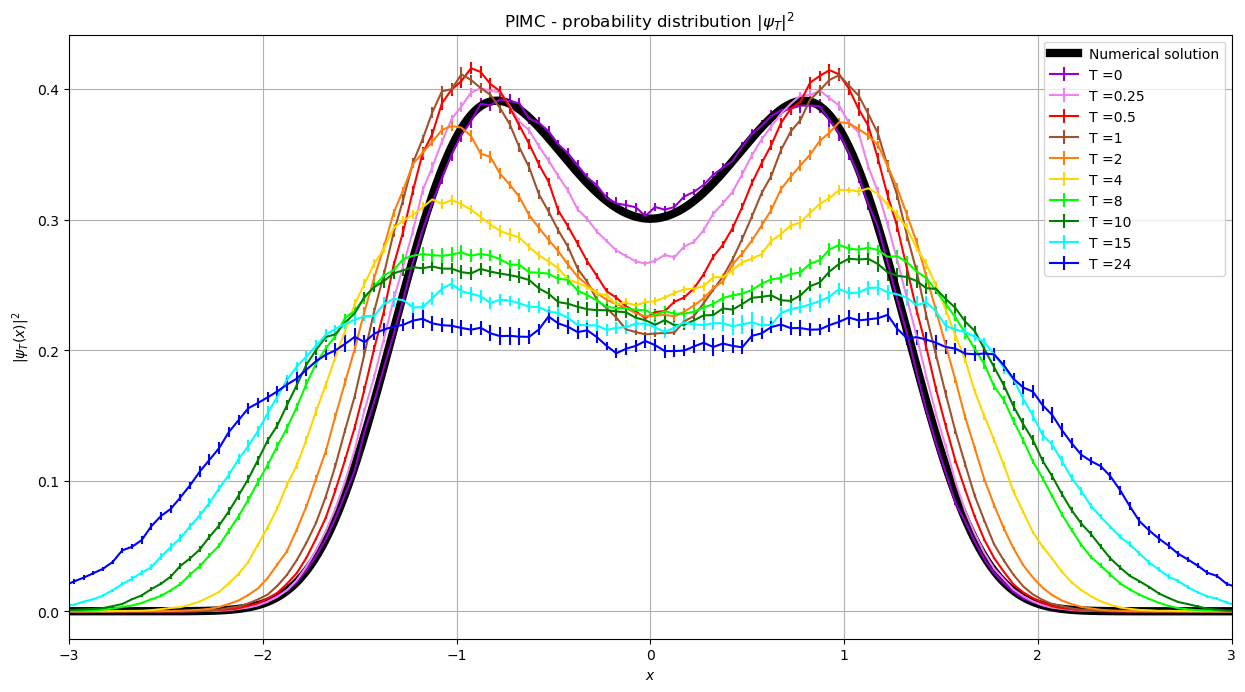

In [78]:
T=[0,0.25,0.5,1,2,4,8,10,15,24]

colors=["darkviolet", "violet","red", "sienna", "C1", "gold", "lime","green", "cyan", "blue"]

figure=plt.figure(figsize=(15,8), dpi = 100)

for i in range(10):
    x_T, y_T, err_T = np.loadtxt("data/ex8.3/PIMC/T"+str(T[i])+"/probability.dat", usecols=(0,1,2), unpack=True)
    plt.errorbar(x_T, y_T,yerr=err_T, color = colors[i], label="T ="+str(T[i]))

plt.plot(x,(psi[0])**2, color="black",linewidth=6, label="Numerical solution")
plt.title("PIMC - probability distribution $|\psi_T|^2$ ")
plt.xlabel(r"$x$")
plt.ylabel(r"$|\psi_T(x)|^2$")
plt.xlim(-3, 3)
plt.legend()
plt.grid(True)

In the above plot, we show the probability density as a function of the temperature.
We can observe that the first effect of the increasing temperature is the widening of the distance between the peaks of the distribution. Contextually to this enlargement, we observe a decrease in the height of the valley which witnesses the increasing contribution of the first excited state.
For high temperatures, and thus for increasing thermal agitation, more an more excited states give their contribution. The result is an increasing superposition of an increasing number of eiengstates which leads to a dstributions that tends to be constant and without peaks.

To confirm what has just been said, we report the numerical calculation of the probability distributions of the first excited states

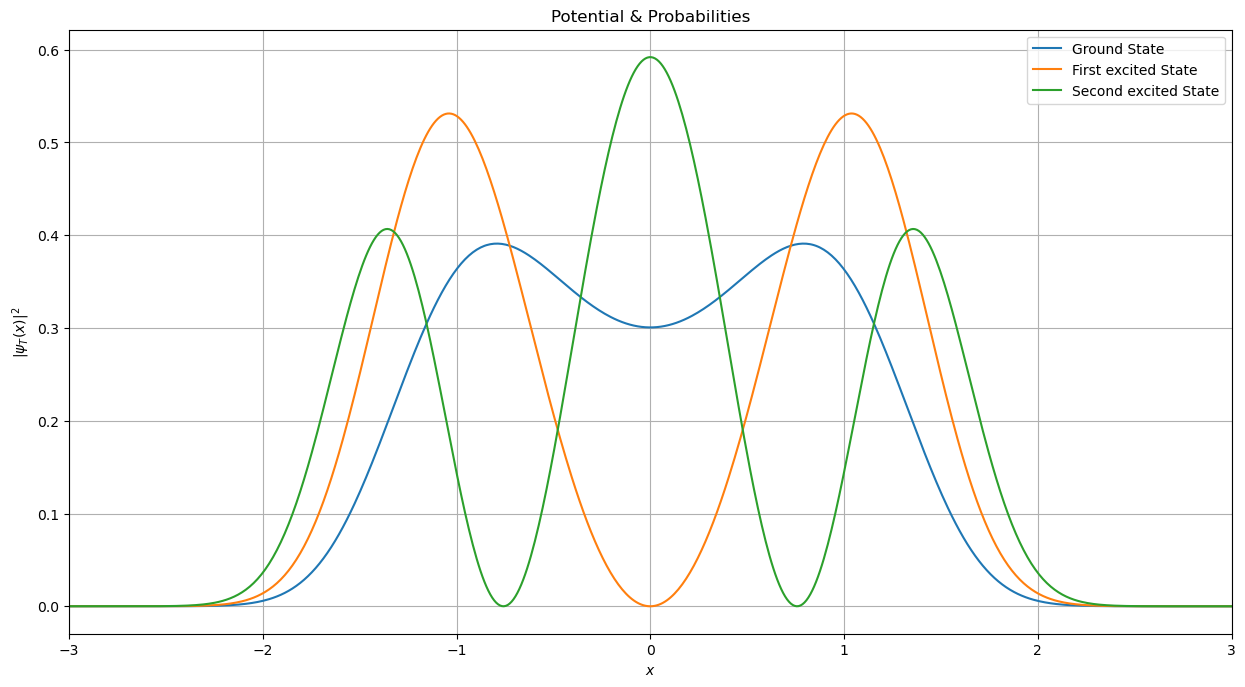

In [86]:
figure=plt.figure(figsize=(15,8), dpi = 100)
plt.title("Potential & Probabilities")

plt.plot(x,(psi[0])**2, label = "Ground State")
plt.plot(x,(psi[1])**2, label = "First excited State")
plt.plot(x,(psi[2])**2, label = "Second excited State")
plt.xlabel("$x$")
plt.ylabel("$|\psi_T(x)|^2$")
plt.grid(True)
plt.xlim((-3,3))
plt.legend()
plt.show()